In [1]:
import matplotlib.pyplot as plt
import tensorflow.keras as k
import numpy as np
from scipy.stats import norm
from scipy.optimize import bisect
from time import time
from sklearn.utils import shuffle

In [2]:

def blackScholesPriceTrue(fwd, strike, mat, vol):
    sqt = vol * np.sqrt(mat)
    d1 = (np.log(fwd / strike) + 0.5 * vol* vol * mat)/sqt
    d2 = d1 - sqt
    n1 = norm.cdf(d1)
    n2 = norm.cdf(d2)
    return n1 - strike/fwd * n2

def blackScholesImliedVol(fwd, strike, mat, price):
    def func(x):        
        return blackScholesPriceTrue(fwd, strike, mat, x) - price
    return bisect(func, 0.00001, 1)

def blackScholesImliedHelper(arr):
    fwd, strike, mat, price = arr
    return blackScholesImliedVol(fwd, strike, mat, price)

def createDatasetIV(size):
    f = np.linspace(0.5, 1.5, size)
    strike = np.linspace(0.5, 1.5, size)
    mat = np.linspace(0.1, 1, size)
    options = np.linspace(0.01, 1, size)
    inputs = np.array(np.meshgrid(f, strike, mat, options)).T.reshape(-1, 4)
    
    vols = list(map(blackScholesImliedHelper, inputs))

    return inputs, vols.flatten()

def createDataset(size):
    f = np.linspace(1,1.5, size)
    strike = np.linspace(0.5,1.5, size)
    mat = np.linspace(0.1,1,size)
    vol = np.linspace(0.01, 0.5, size)
    inputs = np.array(np.meshgrid(f, strike, mat, vol)).T.reshape(-1, 4)
    options = blackScholesPriceTrue(inputs[:, 0],inputs[:, 1], inputs[:, 2], inputs[:, 3])
    vols = inputs[:, [-1]]
    inputs[:, -1] = options 
    return inputs, vols.flatten()

class VolSequence(k.utils.Sequence):

    def __init__(self, dataSetSize, batch_size):
        x, y = createDataset(dataSetSize)
        self.x, self.y = shuffle(x,y, random_state=0)
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size,:]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x, batch_y= shuffle(batch_x, batch_y, random_state=0)
        return batch_x, batch_y


In [3]:

def add_normalized_layer(h_units, activation='relu'):
    return [
        k.layers.Dense(h_units, use_bias=False),
        k.layers.BatchNormalization(),
        k.layers.Activation(activation)
            ]

def create_model(h_layers, h_units, modelFile = None):
    layers = [k.layers.Dense(units=h_units,  input_dim=4)]
    layers +=[k.layers.Dropout(rate=0.9)]
    for _ in range(h_layers):
        layers += add_normalized_layer(h_units, activation='relu')
    layers += [k.layers.Dense(units=h_units//2, activation='relu')]
    layers += [k.layers.Dense(units=1)]
    model = k.models.Sequential(layers)
    optimizer = k.optimizers.RMSprop(lr=0.001, clipnorm=5)
    model.compile(optimizer=optimizer, loss='mse')
    if modelFile is not None:
        try:
            model.load_weights(modelFile)
        except:
            pass
    return model

In [4]:

generator = VolSequence(20,512)
val_generator = VolSequence(5, 5**4)


In [5]:
modelFile = 'bsCalibratorModel.hdf5'
layers = 8
hidden_units = 256
model = create_model(layers, hidden_units, modelFile)

epochs = 0

checkpoint = k.callbacks.ModelCheckpoint(modelFile, monitor='val_loss')
tensorboard = k.callbacks.TensorBoard(log_dir='LOGS\\{}'.format(time()), histogram_freq=10, write_graph=True)
reduce_lr = k.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
model.fit_generator(generator=generator, epochs=epochs, validation_data=val_generator, validation_freq=1, 
                    verbose=1, callbacks=[checkpoint,  reduce_lr])


W0323 14:36:35.651350 25128 deprecation.py:506] From D:\Projects\TweetGenerator\venvp37t2\lib\site-packages\tensorflow\python\ops\init_ops.py:1257: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


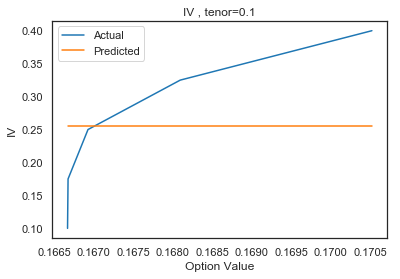

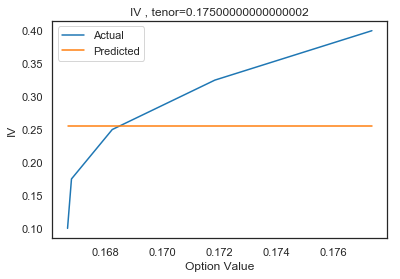

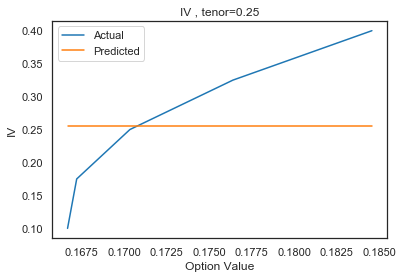

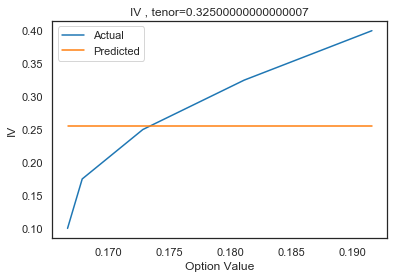

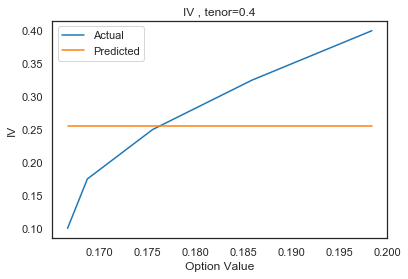

In [6]:
mat = np.linspace(0.1, 0.4, 5)
model = create_model(layers, hidden_units, modelFile)
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
for i in range(5):
    f, strike, t, vol = [1.2], [1], [mat[i]], np.linspace(0.1,0.4, 5)
    inputs = np.array(np.meshgrid(f, strike, t, vol)).T.reshape(-1, 4)
    
    prices = blackScholesPriceTrue(inputs[:, 0], inputs[:, 1], inputs[:, 2], inputs[:, 3])
    vols = inputs[:,[-1]].flatten()
    inputs[:, -1] = prices
    pred_vols = model.predict(inputs)
    plt.figure(i)
    plt.title("IV , tenor={}".format(vols[i]))
    plt.plot(prices, vols, label='Actual')
    plt.plot(prices, pred_vols, label='Predicted')
    plt.xlabel("Option Value")
    plt.ylabel("IV")
    plt.legend()


In [7]:
val_generator.__getitem__(0)[0]

array([[1.50000000e+00, 5.00000000e-01, 5.50000000e-01, 6.66758560e-01],
       [1.37500000e+00, 5.00000000e-01, 1.00000000e-01, 6.36363636e-01],
       [1.37500000e+00, 1.00000000e+00, 7.75000000e-01, 2.72822663e-01],
       ...,
       [1.00000000e+00, 1.00000000e+00, 1.00000000e-01, 1.26156574e-03],
       [1.37500000e+00, 1.00000000e+00, 1.00000000e+00, 3.39280990e-01],
       [1.12500000e+00, 5.00000000e-01, 5.50000000e-01, 5.55555796e-01]])